# Index

* [EDA](#eda)
* [Build and train the model](#sln)
    * [Config](#config)
    * [Constants](#constants)
    * [Helper Functions](#helperfunctions)
    * [Helper Classes](#helperclasses)
    * [Data Pipeline](#datapipeline)
        * [Load data](#loaddata)
        * [Define numerical and categorical pipelines](#numandcatpipelines)
        * [Full Pipeline](#fullpipeline)
        * [Fit the training data into RandomizedSearchCV using hyperparameter grid](#fitting)
        * [Fit the tuned pipeline (best estimator)](#fittingbestestimator)
* [Predict test data and submit result](#submit)

In [1]:
import pandas as pd
import numpy as np
import warnings
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.base import BaseEstimator, TransformerMixin

# estimators
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

## EDA <a class="anchor"  id="eda"></a>

In [2]:
df = pd.read_csv('/kaggle/input/california-housing-dataset/housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
df.sort_values(by='total_rooms', ascending=False).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND
10309,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
6057,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN
12201,-117.20,33.58,2.0,30450.0,5033.0,9419.0,3197.0,4.5936,174300.0,<1H OCEAN


In [7]:
df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

In [8]:
df.corr()

/tmp/ipykernel_21/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


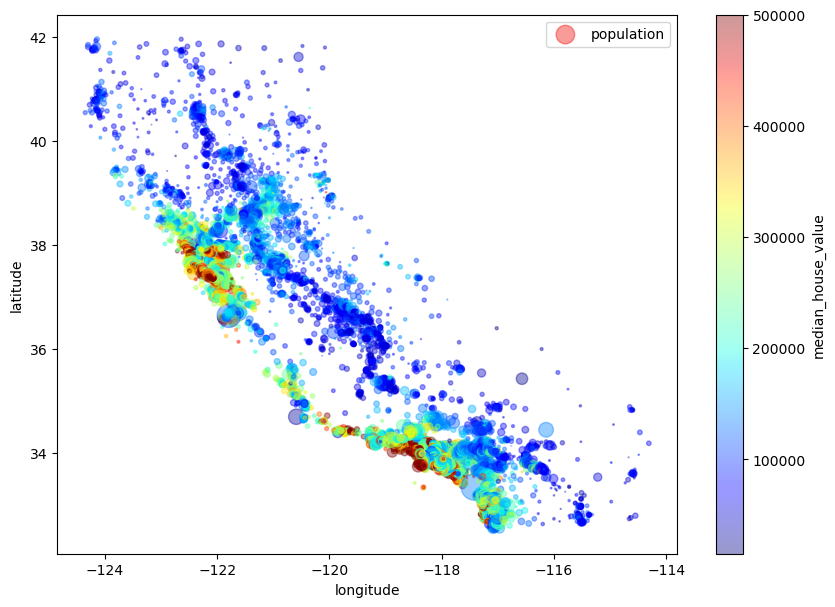

In [9]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=df["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

/tmp/ipykernel_21/2307584126.py:28: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="YlGnBu",annot=True)


<Axes: >

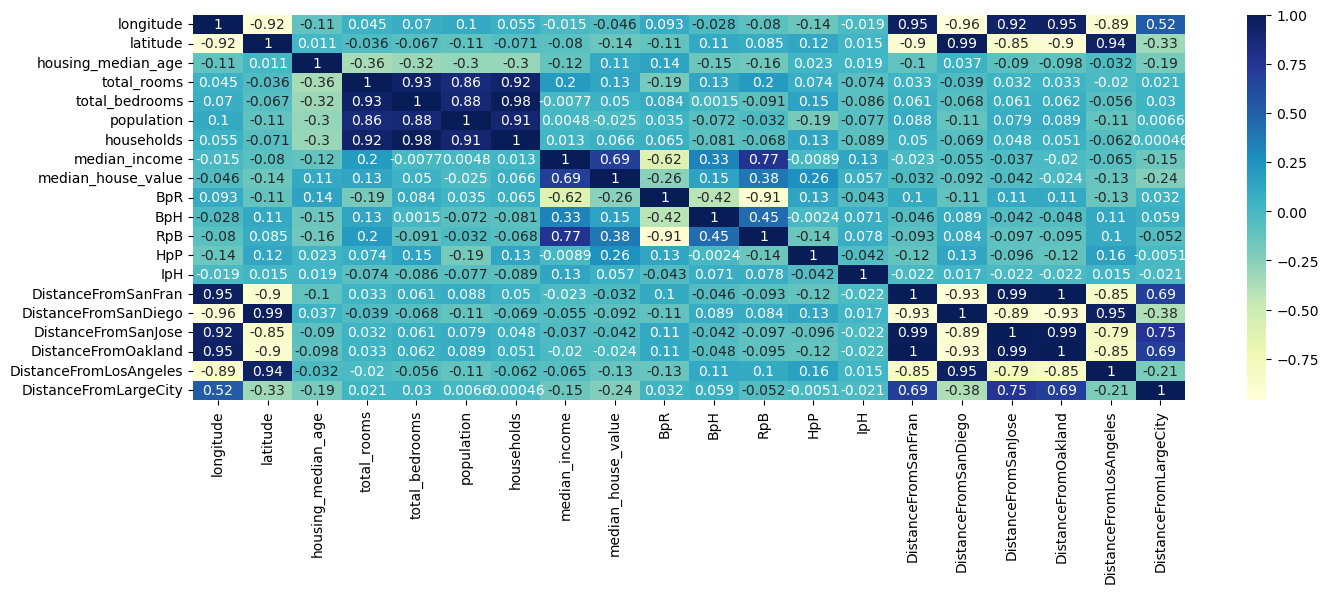

In [10]:
df['BpR'] = df['total_bedrooms'] / df['total_rooms']
df['BpH'] = df['total_rooms'] / df['households']
df['RpB'] = df['total_rooms'] / df['total_bedrooms']
df['RpB'] = df['total_rooms'] / df['total_bedrooms']
df['HpP'] = df['households'] / df['population']
df['IpH'] = df['median_income'] / df['households']

def calc_distance_tmp(row, calc_agaist):
    point = (row['latitude'], row['longitude'])
    distance = geopy.distance.geodesic(point, calc_agaist).km
    return distance

center_of_san_francisco_tmp = (37.756255, -122.444476)
center_of_san_diego_tmp = (32.704489, -117.144796)
center_of_oakland_tmp = (37.805734, -122.265333)
center_of_san_jose_tmp = (37.332897, -121.889197)
center_of_los_angeles_tmp = (34.055108, -118.251056)

df['DistanceFromSanFran'] = df.apply(lambda x: calc_distance_tmp(x, center_of_san_francisco_tmp), axis=1)
df['DistanceFromSanDiego'] = df.apply(lambda x: calc_distance_tmp(x, center_of_san_diego_tmp), axis=1)
df['DistanceFromSanJose'] = df.apply(lambda x: calc_distance_tmp(x, center_of_san_jose_tmp), axis=1)
df['DistanceFromOakland'] = df.apply(lambda x: calc_distance_tmp(x, center_of_oakland_tmp), axis=1)
df['DistanceFromLosAngeles'] = df.apply(lambda x: calc_distance_tmp(x, center_of_los_angeles_tmp), axis=1)
df['DistanceFromLargeCity'] = df['DistanceFromSanFran'] + df['DistanceFromSanDiego'] + df['DistanceFromSanJose'] + df['DistanceFromOakland'] + df['DistanceFromLosAngeles']


plt.figure(figsize=(16,5))
sns.heatmap(df.corr(), cmap="YlGnBu",annot=True)

### Conclusions

- The dataset contains some NULL values. The given data is only missing for a few hundred of `total_bedrooms` column, but we have to think about long-term model deployment, so we'll have to fill NULLs or consider removing missing rows.
- all columns but one are numerical. it's ocean proximity - which is categorical. We'll therefore prepare two pipelines with a `ColumnTransformer` to join them in the master pipeline
- `median_income` has a very high correlation to the price, the rest of the columns are significantly less important.
- coordinates (`longitude`, `latitude`) can be used to calculate distance from large aglomerations - maybe top 5 most expensive cities in california?

## Build and train the model <a class="anchor"  id="sln"></a>

### Config <a class="anchor"  id="config"></a>

In [11]:
set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

### Constants <a class="anchor"  id="constants"></a>

In [12]:
EXCLUDED_COLUMNS =  [
    #'longitude',
    #'latitude',
    #'housing_median_age',
    #'total_rooms',
    #'total_bedrooms',
    #'population',
    #'households',
    #'ocean_proximity'
]

ADDED_NUM_COLUMNS = [
    'DistanceFromLargeCity',
    'BpR',
    'BpH',
    'RpB',
    'HpP'
]

ADDED_CAT_COLUMNS = []

RELATIVE_INPUT_PATH = '/kaggle/input/california-housing-dataset/'
RELATIVE_OUTPUT_PATH = '/kaggle/working/'
FEATURE_LABEL = 'median_house_value'

# coords
center_of_san_francisco = (37.756255, -122.444476)
center_of_san_diego = (32.704489, -117.144796)
center_of_oakland = (37.805734, -122.265333)
center_of_san_jose = (37.332897, -121.889197)
center_of_los_angeles = (34.055108, -118.251056)

### Helper Functions <a class="anchor"  id="helperfunctions"></a>

In [13]:
def load_data():
    return pd.read_csv(f'{RELATIVE_INPUT_PATH}/housing.csv')

def get_categorical_and_numerical_columns(df, excluded_columns, added_cat_columns, added_num_columns):
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

    # deal with excluded
    cat_cols = [i for i in cat_cols if i not in excluded_columns]
    num_cols = [i for i in num_cols if i not in excluded_columns]
    
    # deal with added
    cat_cols = cat_cols + added_cat_columns
    num_cols = num_cols + added_num_columns
    
    print('Numerical columns: ', num_cols)
    print('Categoorical columns: ', cat_cols)
    return cat_cols, num_cols

def separate_features_from_label(df, feature_label):
    labels = df[feature_label]
    features = df.drop(feature_label, axis='columns')
    return features, labels

def write_results(test_pred, _y_test, _X_test, feature_label):
    _X_test[f'{feature_label}-PREDICTED'] = test_pred
    _X_test[feature_label] = _y_test
    _X_test.to_csv(f'{RELATIVE_OUTPUT_PATH}/submission.csv', index=False)
    
def calc_distance(row, calc_agaist):
    point = (row['latitude'], row['longitude'])
    distance = geopy.distance.geodesic(point, calc_agaist).km
    return distance

### Helper Classes <a class="anchor"  id="helperclasses"></a>

In [14]:
# custom transformer
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        distanceFromSanFran = X.apply(lambda x: calc_distance(x, center_of_san_francisco), axis=1)
        distanceFromSanDiego = X.apply(lambda x: calc_distance(x, center_of_san_diego), axis=1)
        distanceFromSanJose = X.apply(lambda x: calc_distance(x, center_of_san_jose), axis=1)
        distanceFromOakland = X.apply(lambda x: calc_distance(x, center_of_oakland), axis=1)
        distanceFromLosAngeles = X.apply(lambda x: calc_distance(x, center_of_los_angeles), axis=1)
        
        X['DistanceFromLargeCity'] = distanceFromSanFran + distanceFromSanDiego + distanceFromSanJose + distanceFromOakland + distanceFromLosAngeles
        
        X['BpR'] = X['total_bedrooms'] / X['total_rooms']
        X['BpH'] = X['total_rooms'] / X['households']
        X['RpB'] = X['total_rooms'] / X['total_bedrooms']
        X['RpB'] = X['total_rooms'] / X['total_bedrooms']
        X['HpP'] = X['households'] / X['population']
        return X
    
class ColumnDropper(BaseEstimator, TransformerMixin):
    # PREMISE OF COLUMN DROPPER ARE FEATURE IMPORTANCES
    # [(0.5368598125868113, 'num__median_income'),
    #  (0.1670943815527636, 'cat__ocean_proximity_INLAND'),
    #  (0.09000450233693275, 'num__HpP'),
    #  (0.052462586203427405, 'num__longitude'),
    #  (0.05095947262956985, 'num__DistanceFromLargeCity'),
    #  (0.04416090094106515, 'num__latitude'),
    #  (0.025996967861273996, 'num__housing_median_age'),
    #  (0.009765014109311089, 'num__BpH'),
    #  (0.004841649729687324, 'cat__ocean_proximity_NEAR OCEAN'),
    #  (0.003629938002492446, 'num__BpR'),
    #  (0.0030479759069477956, 'num__RpB'),
    #  (0.0029550357044442997, 'cat__ocean_proximity_NEAR BAY'),
    #  (0.0027957242642671866, 'num__total_rooms'),
    #  (0.002225106020731476, 'num__total_bedrooms'),
    #  (0.0014230506106551306, 'num__population'),
    #  (0.0013258638412647693, 'num__households'),
    #  (0.00040664301346999903, 'cat__ocean_proximity_<1H OCEAN'),
    #  (4.537468488441263e-05, 'cat__ocean_proximity_ISLAND')]
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    # only keep columns that have more than 0% impact
    def transform(self, X, y=None):
        features_to_keep = [
            'num__median_income',
            'cat__ocean_proximity_INLAND',
            'num__HpP',
            'num__longitude',
            'num__DistanceFromLargeCity',
            'num__latitude',
            'num__housing_median_age'
        ]
        return X[features_to_keep]


### Data Pipeline <a class="anchor"  id="datapipeline"></a>

#### Load Data <a class="anchor"  id="loaddata"></a>

In [15]:
dataset = load_data()
X, y = separate_features_from_label(dataset, FEATURE_LABEL)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('=====================================================')
print('COLUMNS:')
print(X_train.columns)

(16512, 9) (4128, 9) (16512,) (4128,)
COLUMNS:
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')


#### Define numerical and categorical pipelines <a class="anchor"  id="numandcatpipelines"></a>

In [16]:
# split columns into categorical and numerical
cat_cols, num_cols = get_categorical_and_numerical_columns(X_train, EXCLUDED_COLUMNS, ADDED_CAT_COLUMNS, ADDED_NUM_COLUMNS)


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

column_transformer = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
])

Numerical columns:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'DistanceFromLargeCity', 'BpR', 'BpH', 'RpB', 'HpP']
Categoorical columns:  ['ocean_proximity']


#### Full Pipeline <a class="anchor"  id="fullpipeline"></a>

In [17]:

full_pipeline = Pipeline([
    ('preprocessor', Preprocessor()),
    ('column_transformer', column_transformer),
    ('estimator', {})
])

#### Fit the training data into RandomizedSearchCV using hyperparameter grid <a class="anchor"  id="fitting"></a>

In [18]:
# param_grid = {
#     'column_transformer__num__imputer__strategy': ['mean', 'median'],
# }

# regressors = {
#     LinearRegression(): {},
#     GradientBoostingRegressor(): {
#         'estimator__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
#         'estimator__n_estimators': sp_randInt(100, 1000),
#         'estimator__subsample': sp_randFloat(),
#         'estimator__criterion': ['friedman_mse', 'squared_error'],
#         'estimator__ccp_alpha': sp_randFloat(0, 10)
#     },
#     ElasticNet(): {
#         'estimator__selection': ['cyclic', 'random']
#     },
#     SGDRegressor(): {
#         'estimator__loss': ['squared_error', 'squared_epsilon_insensitive', 'epsilon_insensitive', 'huber'],
#         'estimator__alpha': sp_randFloat(),
#         'estimator__epsilon': sp_randFloat(),
#         'estimator__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
#     },
#     SVR(): {
#         'estimator__degree': sp_randInt(1, 10),
#         'estimator__gamma': ['scale', 'auto'],
#         'estimator__C': sp_randFloat(0, 5),
#         'estimator__shrinking': [True, False],
#     },
#     KernelRidge(): {
#         'estimator__alpha': sp_randFloat(0, 5),
#         'estimator__degree': sp_randInt(2, 5),
#     },
#     RandomForestRegressor(): {
#         'estimator__n_estimators': sp_randInt(100, 1000),
#         'estimator__criterion': ['friedman_mse', 'squared_error'],
#         'estimator__ccp_alpha': sp_randFloat(0, 10),
#         'estimator__bootstrap': [True, False]
#     },
# }

# model_scores = {}

# estimator_index = 2
# k_fold = 10
# for model, estimator_param_grid in regressors.items():
#     # replace the estimator
#     full_pipeline.steps.pop(estimator_index)
#     full_pipeline.steps.insert(estimator_index,['estimator', model])
    
#     # add estimator hyperparameters
#     joint_param_grid = dict(param_grid, **estimator_param_grid)
    
#     # perform search
#     print(f'running for {model} and params:{joint_param_grid}')

#     search_results = RandomizedSearchCV(full_pipeline, joint_param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=k_fold)
#     search_results.fit(X_train, y_train)

#     # save metadata
#     model_scores[model] = search_results
    
#     # print tuned pipeline metadata
#     #print(f'tuned hyperparameters :(best parameters) ', search_results.best_params_)
#     print(f'{model} score :', search_results.best_score_)
#     print(f'{model} sqrt of score :', np.sqrt(-search_results.best_score_))
#     #print(f' best estimator: {search_results.best_estimator_}')    
    

### Output of the above search:

```python
LinearRegression() score : -4272132755.4045777
LinearRegression() sqrt of score : 65361.55410793548
GradientBoostingRegressor() score : -2235332662.362297
GradientBoostingRegressor() sqrt of score : 47279.304799904756 # <--- lowest error
ElasticNet() score : -5365048743.45672
ElasticNet() sqrt of score : 73246.49304544703
SGDRegressor() score : -4320092001.511789
SGDRegressor() sqrt of score : 65727.40677610664
SVR() score : -13779677500.910192
SVR() sqrt of score : 117386.87107556021
KernelRidge() score : -4273526216.507219
KernelRidge() sqrt of score : 65372.21287754621
RandomForestRegressor() score : -2382565995.5008407
RandomForestRegressor() sqrt of score : 48811.53547575451
RandomForestRegressor() 48811.53547575451
```

In [19]:
# sorted_scores = dict(sorted(model_scores.items(), key=lambda item: item[1].best_score_, reverse=True))
# model_feature_importances = {}

# for k, v in sorted_scores.items():
#     print(k, np.sqrt(-v.best_score_))
#     print(k, v.best_estimator_)
    
#     # mock preprocessing to extract columns
#     attributes = v.best_estimator_.named_steps['column_transformer'].transform(
#         v.best_estimator_.named_steps['preprocessor'].transform(X_train, y_train)
#     ).columns
#     feature_importances = v.best_estimator_.named_steps['estimator'].feature_importances_
    
#     fi = sorted(zip(feature_importances, attributes), reverse=True)
#     print(fi)
#     model_feature_importances[k] = fi


#### Fit the tuned pipeline (best estimator) <a class="anchor"  id="fittingbestestimator"></a>

The above code takes a long time to run, so below is an output of the best estimator - basically a tuned pipeline with the best hyperparameter combination

In [20]:
## Best estimator choice

search_results = Pipeline(steps=[
    ('preprocessor', Preprocessor()),
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer()),
                ('scaler', StandardScaler())]), ['longitude', 'latitude',
                                                       'housing_median_age',
                                                       'total_rooms',
                                                       'total_bedrooms',
                                                       'population', 'households',
                                                       'median_income',
                                                       'DistanceFromLargeCity',
                                                       'BpR', 'BpH', 'RpB',
                                                       'HpP']),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('one_hot_encoder', OneHotEncoder(sparse=False))]), ['ocean_proximity'])])),
    ('column_dropper', ColumnDropper()),
    ['estimator', GradientBoostingRegressor(ccp_alpha=9.574054038251486,
                                           loss='huber', n_estimators=389,
                                           subsample=0.8725635767412397)]])

search_results.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'DistanceFromLargeCity',
                                                   'BpR', 'BpH', 'RpB',
                                                   'HpP']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['ocean_proximity'])])),
                ('column_dropper', ColumnDropper()),
                ['estimator',
                 GradientBoostingRegressor(ccp_alpha=9.574054038251486,
                                           loss='huber', n_estimators=389,
                                           subsample=0.8725635767412397)]])

## Predict test data and submit results <a class="anchor"  id="submit"></a>

In [21]:
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
10608,-117.78,33.68,14.0,1750.0,336.0,852.0,300.0,4.6793,<1H OCEAN
15480,-117.13,33.15,15.0,2241.0,381.0,997.0,390.0,3.4833,<1H OCEAN
15752,-122.44,37.77,52.0,3475.0,807.0,1518.0,777.0,3.6186,NEAR BAY
5395,-118.37,34.04,25.0,542.0,161.0,442.0,131.0,2.2500,<1H OCEAN
13153,-121.60,36.88,21.0,3416.0,624.0,1862.0,595.0,4.7813,<1H OCEAN


In [22]:
# predict and write test data results/submission
yhat = search_results.predict(X_test)
write_results(yhat, y_test, X_test, FEATURE_LABEL)

final_mse = mean_squared_error(y_test, yhat)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,668.25
final_rmse

49473.3820218113